#Bike Share Study Case

######Date: September 11th, 2023
######Author: Eduardo Arriaga Balderas



##Introduction

The following report was made to analyse a company called Cyclistic, which operates in Chicago with a service of bicycle lending. This company started at 2016, and it currently has more than 5,800 bicycles in operations, with a network of 692 stations where anybody can take and leave one of their bikes.

Currently, the company has two sectors of users: casual and members. Casual users are those who pay for a single-ride or full-day passes. By the other hand, member users is anybody that pays for their annual membership.

What this analysis will do is to answer three key questions:

-	How do annual members and casual riders use Cyclistic bikes differently?
-	Why would casual riders buy Cyclistic annual membership?
-	How can Cyclistic use digital media to influence casual riders to become members?

With the insights gained on this project, we'll be able to propose some actions to increase the member user base with a marketing campaing.

##Ask

The problem to solve is to find the answers to the key questions. Answering them can generate the company an increase in revenues and stock value, because of an increase in the member user base. This achieve can be solved by studying the characteristics that differ between a member and a casual user, which after discovered, we will be able to make accurate recomendations. This characteristics must be the dorsal spin that leads the next marketing campaign.

The current research will be driven by the process of Ask, Prepare, Process, Analyze, Share, and Act, a method proposed by Google to analyze data effectively. And the tools used are the Python data analysis libraries, such as Pandas, Matplotlib, and Numpy, including some others like datetime, and google.colab.

##Prepare

Data has been gotten publicly from the company. The data is a collection of 12 datasets, each one corresponding to every month from June 2022 to May 2023. All of the datasets share the same variables:
-	ride_id: a unique combination of numbers and capital letters made to differentiate each travel.  
-	rideable_type: type of bicycle used during the trip. It can electric, classic or doked.
-	started_at: date and hour at which the trip started.
-	ended_at: date and hour at which the trip started.
-	start_station_name: name of the station where the trip started.
-	start_station_id: id of the station where the trip started.
-	end_station_name: name of the station where the trip started.
-	end_station_id: id of the station where the trip started.
-	start_lat: latitude of the starting location.
-	start_lng: longitude of the starting location.
-	end_lat: latitude of the ending location.
-	end_lng: longitude of the ending location.
-	member_casual: type of user that made the trip. It can be member or casual.

As this data is provided by the company, it has all the required licensing, privacy, accuracy, and accessibility required. The data integrity is guaranteed by the primary source, the company. These two facts helped us to answer the questions by giving us the data needed.

The first step to take is to start the preparation of the dataset by importing all twelve datasets, and then merging them to work more effectively.

In [1]:
#Set google acccount as the source of the datasets previously uploaded.
from google.colab import drive, files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Now we import the datasets and libraries to use.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

location = "gdrive/MyDrive/Projects/Bike-share/Bike-share_data/"

data_sets = ["202206-divvy-tripdata.csv",
             "202207-divvy-tripdata.csv",
             "202208-divvy-tripdata.csv",
             "202209-divvy-tripdata.csv",
             "202210-divvy-tripdata.csv",
             "202211-divvy-tripdata.csv",
             "202212-divvy-tripdata.csv",
             "202301-divvy-tripdata.csv",
             "202302-divvy-tripdata.csv",
             "202303-divvy-tripdata.csv",
             "202304-divvy-tripdata.csv",
             "202305-divvy-tripdata.csv"]

#Mergin the data

df = pd.read_csv(location + data_sets[0])
total_length = len(df.index)


for i in range(1,len(data_sets)):
    df_to_append = pd.read_csv(location + data_sets[i])
    length_of_df = len(df_to_append.index)
    total_length += length_of_df
    df = pd.concat((df, df_to_append), axis = 0)

#Changing the data format for ended_at and started_at to datetime format
df['ended_at']= pd.to_datetime(df['ended_at'],
                               utc = True)
df['started_at']= pd.to_datetime(df['started_at'],
                                 utc = True)

df.replace({'rideable_type': {"classic_bike": "classic",
                              "electric_bike": "electric",
                              "docked_bike": "docked"}}, inplace = True)


##Process

We firstly drop the diplicated rows.

In [3]:
df_duplicated = df.copy()
df = df_duplicated.drop_duplicates()
print(f"Number of duplicated rows: {len(df_duplicated) - len(df)}")

Number of duplicated rows: 0


Checking for missing values for every column, we found the following:

In [4]:
missing = pd.DataFrame(df.isna().sum())
missing.reset_index(inplace= True, names = "Variable")
missing["Missing data"] = missing.iloc[:, 1]
missing.drop(missing.columns[1], axis = 1, inplace = True)
missing["% of total data"] = ((missing["Missing data"] / len(df.index))*100).round(2)
missing.set_index("Variable", inplace = True)
total_missing_rows = len(df.index) - len(df.dropna().index)

missing["% of total missing"] = ((missing["Missing data"] / total_missing_rows)*100).round(2)

print(missing.sort_values(by = "Missing data", ascending = False))

print(f"Total missing rows: {total_missing_rows}")

                    Missing data  % of total data  % of total missing
Variable                                                             
end_station_id            891898            15.30               66.84
end_station_name          891757            15.30               66.83
start_station_id          834677            14.32               62.55
start_station_name        834545            14.32               62.54
end_lat                     5961             0.10                0.45
end_lng                     5961             0.10                0.45
ride_id                        0             0.00                0.00
rideable_type                  0             0.00                0.00
started_at                     0             0.00                0.00
ended_at                       0             0.00                0.00
start_lat                      0             0.00                0.00
start_lng                      0             0.00                0.00
member_casual       

The four variables with more missing values are start_station_name, start_station_id, end_station_name, start_station_id, followed by end_lat and end_lng as the ones with the least missing values. All these six variables represent a total of 1,334,349 rows. Rows that contain at least one missing value in any of the columns mentioned before.

We found that data’s integrity could be compromised when cleaning all the missing values. The reason for this is that, when skipping them, we lose a total of 22.89% of the data. This is a problem because the omission of the missing information from start_station_name, start_station_id, end_station_name, and end_station_id, changes proportions for rideable_type preferences. In the following code, it can be seen that the differences after skipping all the missing values in the four columns mentioned above can lead to a serious bias, when analyzing preferences in rideable_type. We also included the proportions of lost data after dropping missing values in the rest of the columns.

By the other hand, in member_casual the deletion of rows in the columns mentioned above does not affect in a important way.

In [5]:
#Dropping missing values in different columns
df_0 = df.copy() #Make a copy of the original dataframe
#Drop missing in end_lat, end_lng, proportions don't change.
df_1 = df_0.dropna(subset = ["end_lat", "end_lng"]).copy()
#Drop missing in start_station_name and end_station_name, proportions change.
df_2 = df_0.dropna(subset = ["start_station_name", "end_station_name"]).copy()
#Drop all missing values, proportions change.
df_3 = df_0.dropna().copy()
#Drop missing in start_station_id and end_station_id, proportions change.
df_4 = df_0.dropna(subset = ["start_station_id", "end_station_id"]).copy()


In [6]:
data_frames = [df_0, df_1, df_2, df_3, df_4]

def users_proportions(df_vn, df_v0):
    users = np.array([
        #Cleaned dataframe
        [df_vn["member_casual"].value_counts()["member"],
         df_vn["member_casual"].value_counts()["casual"],
         #Totals
         df_vn["member_casual"].value_counts()["casual"]+df_vn["member_casual"].value_counts()["member"]],
         #Dirty dataframe
        [df_v0["member_casual"].value_counts()["member"],
         df_v0["member_casual"].value_counts()["casual"],
         #Totals
         df_v0["member_casual"].value_counts()["casual"]+df_v0["member_casual"].value_counts()["member"]]
    ])

    print(f"Proportions:",
          "\n - Cleaned:",
          f"\n -- casuals: {round((users[0,0]/users[0,2])*100, 2)}%",
          f"\n -- members: {round((users[0,1]/users[0,2])*100, 2)}%",
          "\n - Dirty:",
          f"\n -- casuals: {round((users[1,0]/users[1,2])*100, 2)}%",
          f"\n -- members: {round((users[1,1]/users[1,2])*100, 2)}%")
    print()

def ride_type_proportions(df_vn, df_v0):
    ride_type = np.array([
        #Cleaned df
        [df_vn["rideable_type"].value_counts()["classic"],
         df_vn["rideable_type"].value_counts()["electric"],
         df_vn["rideable_type"].value_counts()["docked"],
         df_vn["rideable_type"].value_counts()["classic"]+df_vn["rideable_type"].value_counts()["electric"]+df_vn["rideable_type"].value_counts()["docked"]],
         #Dirty df
         [df_v0["rideable_type"].value_counts()["classic"],
         df_v0["rideable_type"].value_counts()["electric"],
         df_v0["rideable_type"].value_counts()["docked"],
         df_v0["rideable_type"].value_counts()["classic"]+df_v0["rideable_type"].value_counts()["electric"]+df_v0["rideable_type"].value_counts()["docked"]]
    ])
    print(f"Proportions for type of bike:",
          "\n - Cleaned:",
          f"\n -- classic: {round((ride_type[0,0]/ride_type[0,3])*100, 2)}%",
          f"\n -- electric: {round((ride_type[0,1]/ride_type[0,3])*100, 2)}%",
          f"\n -- docked: {round((ride_type[0,2]/ride_type[0,3])*100, 2)}%"
          "\n - Dirty:",
          f"\n -- classic: {round((ride_type[1,0]/ride_type[1,3])*100, 2)}%",
          f"\n -- electric: {round((ride_type[1,1]/ride_type[1,3])*100, 2)}%",
          f"\n -- docked: {round((ride_type[1,2]/ride_type[1,3])*100, 2)}%")
    print()

def data_loss(df_vn, df_v0):
    print("Proportions of data loss after cleaning all misssing values:",
          f"\ndf_clean - df_dirty = {len(df_vn.index)-len(df_v0.index)}",
          f"\nPercentage of data loss: {round((1-(len(df_vn.index)/len(df_v0.index)))*100, 2)} %")

def printing_proportions_for_df(data_frames):
    for i in range(1, len(data_frames)):
        print(f"Data frame number: {i}")
        print(f"Length of the data frame: {len(data_frames[i].index)}")
        users_proportions(data_frames[i], data_frames[0])
        ride_type_proportions(data_frames[i], data_frames[0])
        data_loss(data_frames[i], data_frames[0])
        print("\n\n")

printing_proportions_for_df(data_frames)


Data frame number: 1
Length of the data frame: 5823069
Proportions: 
 - Cleaned: 
 -- casuals: 60.38% 
 -- members: 39.62% 
 - Dirty: 
 -- casuals: 60.34% 
 -- members: 39.66%

Proportions for type of bike: 
 - Cleaned: 
 -- classic: 44.4% 
 -- electric: 52.95% 
 -- docked: 2.65%
 - Dirty: 
 -- classic: 44.41% 
 -- electric: 52.9% 
 -- docked: 2.7%

Proportions of data loss after cleaning all misssing values: 
df_clean - df_dirty = -5961 
Percentage of data loss: 0.1 %



Data frame number: 2
Length of the data frame: 4494927
Proportions: 
 - Cleaned: 
 -- casuals: 61.11% 
 -- members: 38.89% 
 - Dirty: 
 -- casuals: 60.34% 
 -- members: 39.66%

Proportions for type of bike: 
 - Cleaned: 
 -- classic: 57.51% 
 -- electric: 39.05% 
 -- docked: 3.44%
 - Dirty: 
 -- classic: 44.41% 
 -- electric: 52.9% 
 -- docked: 2.7%

Proportions of data loss after cleaning all misssing values: 
df_clean - df_dirty = -1334103 
Percentage of data loss: 22.89 %



Data frame number: 3
Length of the data 

Mainly because of this, we have decided not to get rid of the missing rows in  start_station_name, start_station_id, end_station_name, and end_station_id, and continue our analysis just deleting missing values in the rest of the columns. This configuration is barely noticed when we look at proportions again, the reason of it is that the data deleted only represented 5,961 rows (0.1% of the data).

We saw necessary to create some new variables too:
-	week_day_n: the day of the week when trip was made. The day is represented by a number, with 1 being Monday, and 7 being Sunday.
-	week_day: the day of the week when trip was made.
-	ride_length: the duration of the trip in minutes. This variable was created by subtracting the end-date from the start-date, converting it to seconds as int64 format, and dividing it by 60.
- ride_length_hrs: the duration of the trip in hrs. This variable was made by dividing the ride_length column over 60.


In [6]:
#Create a column for the day of the week
df_1["week_day_n"] = pd.to_datetime(df_1["started_at"]).dt.weekday
df_1["week_day"] = pd.to_datetime(df_1["started_at"]).dt.day_name()

#Create a column for the length of the trips in minutes
df_1["ride_length_dirty"] = pd.to_datetime(df_1["ended_at"]) - pd.to_datetime(df_1["started_at"])
df_1["ride_length"] = df_1['ride_length_dirty'].dt.total_seconds().astype("int64")/60

#Create a column for the length of the trips in hours.
df_1["ride_length_hrs"] = df_1["ride_length"]/60

#Month variable
df_1["month_n"] = pd.to_datetime(df_1["started_at"]).dt.month
df_1["month"] = pd.to_datetime(df_1["started_at"]).dt.month_name()

#Create a column of end_date and start_date without time.
df_1["end_date"] = pd.to_datetime(df_1["ended_at"]).dt.date
df_1["start_date"] = pd.to_datetime(df_1["started_at"]).dt.date

#Dropping negative values for ride_length
df_5 = df_1.copy()
df_1 = df_5[df_5["ride_length"] > 0]


Watching closely to the ride lengths, we can see that there are trips that lasted more than 8 hours, and even worse, some trips lasted 22 days.

In [7]:
x5 = df_1.copy()
print("Length by hours")
print(x5["ride_length_hrs"].describe().round(2))

print("\nLength by days")
days = x5["ride_length_hrs"]/24

print(days.describe().round(2))

Length by hours
count    5822502.00
mean           0.26
std            0.55
min            0.00
25%            0.09
50%            0.16
75%            0.29
max          533.92
Name: ride_length_hrs, dtype: float64

Length by days
count    5822502.00
mean           0.01
std            0.02
min            0.00
25%            0.00
50%            0.01
75%            0.01
max           22.25
Name: ride_length_hrs, dtype: float64


Because of this, we are assuming that trips are no longer than 4 hours, assuming at the same time that some trips were made for fun and recreational reasons. Taking that in consideration, we are classifying trips longer than 4 hours as missing values too.
After this modification, we perceive a more normaly distributed graph about the amount of trips against the duration of them.

Trips longer than 4 hours: 8006

Length of trips in minutes
count    5814496.00
mean          14.83
std           17.52
min            0.02
25%            5.58
50%            9.83
75%           17.53
max          240.00
Name: ride_length, dtype: float64



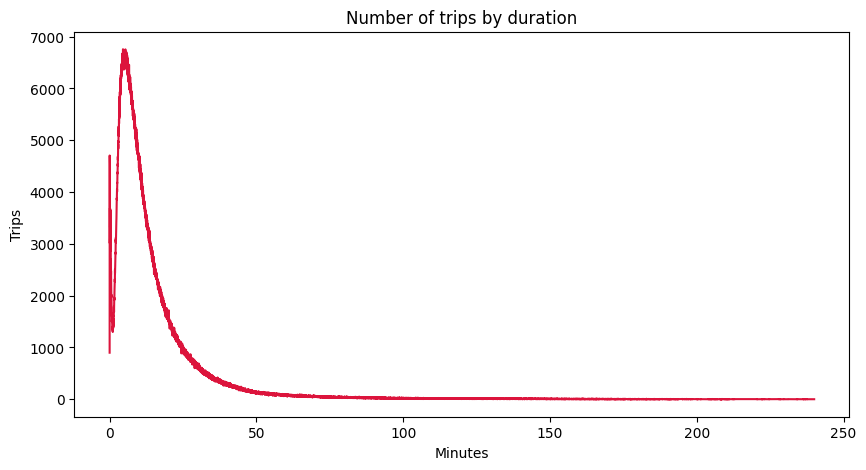

In [8]:
df_temp = df_1.copy()

df_1 = df_temp[df_temp["ride_length_hrs"] <= 4].copy()

print(f"Trips longer than 4 hours: {len(df_temp.index) - len(df_1.index)}\n")

print("Length of trips in minutes")
print(df_1["ride_length"].describe().round(2))
print()

plt.figure(figsize = (10, 5))
x5 = pd.crosstab(df_1["ride_length"], columns = "count")
x_axis = x5.index
y_axis = x5["count"]
plt.title("Number of trips by duration")
plt.plot(x_axis, y_axis, color = "crimson")
plt.xlabel("Minutes")
plt.ylabel("Trips")
plt.show()

##Analyze

Before starting, we created functions that will help us to make important graphs and to perform important mathematical operations.


In [9]:
#Functions for graphing

wide = 12

def line_plot(variable, counting):
    #Plotting
    fig, ax = plt.subplots(figsize = (wide, 6))
    x_axis = variable.index
    y_axis = variable[counting]
    ax.plot(x_axis, y_axis)
    plt.show()

def double_line_graph(ts_1, ts_2, label_1, label_2, title):
    if len(ts_1.index) == len(ts_2.index):
        x_axis = ts_1.index
        y_axis_1 = ts_1["count"]
        y_axis_2 = ts_2["count"]
        plt.title(title)
        plt.plot(x_axis, y_axis_1, label = label_1)
        plt.plot(x_axis, y_axis_2, label = label_2)
        plt.legend()
        plt.show()
    else:
        print(f"df 1 and df 2 have different length.\n"+
              f"lengths: df 1 = {len(ts_1.index)}, df 2 = {len(ts_2.index)}")


def triple_line_graph(ts_1, ts_2, ts_3, label_1, label_2, label_3, title):
    if len(ts_1.index) == len(ts_2.index) == len(ts_3.index):
        x_axis = ts_1.index
        y_axis_1 = ts_1["count"]
        y_axis_2 = ts_2["count"]
        y_axis_3 = ts_3["count"]
        plt.plot(x_axis, y_axis_1, label = label_1)
        plt.plot(x_axis, y_axis_2, label = label_2)
        plt.plot(x_axis, y_axis_3, label = label_3)
        plt.title(title)
        plt.legend()
        plt.show()
    else:
        print(f"ts_1, ts_2 and ts_3 have different length.\n"+
              f"lengths:\n ts_1 = {len(ts_1.index)}\n ts_2 = {len(ts_2.index)}\n ts_3 = {len(ts_3.index)}")

def single_bar_graph(x_axis, y_axis, x_label =None, y_label = None, title_label = None,
                     color = None, frequency_x_label = 2):
    x = x_axis
    y = y_axis

    fig = plt.figure(figsize = (wide, 5))
    plt.bar(x, y, color = color,
            width = 0.4)

    plt.xticks(x_axis[0:len(x_axis):frequency_x_label])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title_label)
    plt.show()


def double_bar_graphs(ts_1, ts_2, label_1, label_2, title):
    barwidth = 0.25
    fig = plt.figure(figsize = (wide, 10))
    br1 = np.arange(len(ts_1.index))
    br2 = [x + barwidth for x in br1]

    plt.bar(br1, ts_1["count"], color = "crimson", width = barwidth,
            edgecolor = "grey", label = label_1)
    plt.bar(br2, ts_2["count"], color = "steelblue", width = barwidth,
            edgecolor = "grey", label = label_2)
    plt.title(title)
    plt.xticks([r + barwidth for r in range(len(ts_1))],
               list(ts_1["month_name"]))
    plt.legend()
    plt.show()


def bar_graphs(ts_1, ts_2, ts_3, label_1, label_2, label_3, title):
    barwidth = 0.25
    fig = plt.figure(figsize = (wide, 10))
    br1 = np.arange(len(ts_1.index))
    br2 = [x + barwidth for x in br1]
    br3 = [x + barwidth for x in br2]

    plt.bar(br1, ts_1["count"], color = "mediumseagreen", width = barwidth,
            edgecolor = "grey", label = label_1)
    plt.bar(br2, ts_2["count"], color = "indianred", width = barwidth,
            edgecolor = "grey", label = label_2)
    plt.bar(br3, ts_3["count"], color = "royalblue", width = barwidth,
            edgecolor = "grey", label = label_3)
    plt.title(title)
    plt.xticks([r + barwidth for r in range(len(ts_1))],
               list(ts_1["month_name"]))
    plt.legend()
    plt.show()

#Functions for groupping sums and means

def getting_time_series(df, filter_col, condition, date_index):
    new_frame = df.loc[df[filter_col] == condition].copy()
    new_frame = new_frame[[date_index, filter_col]].copy()
    return pd.crosstab(new_frame[date_index], columns= "count")

def grouping_time_series(df, type_of_operation):
    if type_of_operation == "sum":
        new_df = df.groupby([lambda x: x.year, lambda x: x.month]).sum()
    elif type_of_operation == "mean":
        new_df = df.groupby([lambda x: x.year, lambda x: x.month]).mean()
    new_df.index.rename(["year", "month"], inplace=True)
    new_df = new_df.reset_index()
    new_df["day"] = "01"
    new_df["date"] = new_df['year'].astype(str) +"-"+ new_df["month"].astype(str) +"-"+ new_df["day"]
    new_df["month_name"] = pd.to_datetime(new_df["date"]).dt.month_name()
    new_df.drop(["year", "month", "day"], axis = 1, inplace = True)
    new_df["date"] = pd.to_datetime(new_df["date"])
    new_df.set_index("date", inplace = True)
    return new_df


###User base

Member users are more likely to do bike trips than Casual users. But, it is needed to say that the difference between these two is not big. This may be because of two causes: tourists that visit the city of Chicago every year and people from the city that don't take bycicles as its first transport media.  

For us, Casual users represent these two sectors. We assume that tourist don't go to Chicago in winter as much as they do in summer, and taking out this difference in bike trips, we would have the local Casual users. These local casual users are still a big part of the trips made.

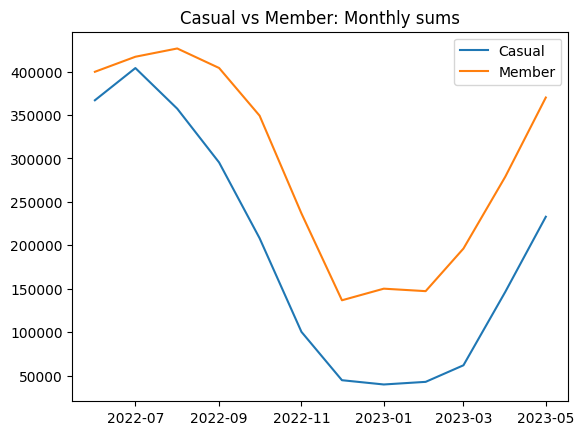

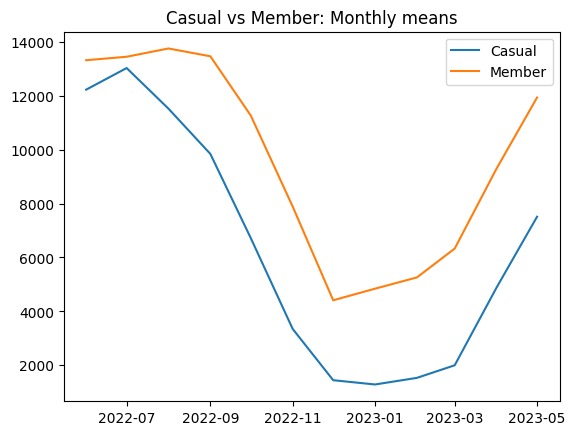

In [10]:
df_casual_count = getting_time_series(df_1, "member_casual", "casual", "start_date")
# Had to delete before graphin so lengths match
#df_casual_count = df_casual_count.drop([df_casual_count.index])
df_member_count = getting_time_series(df_1, "member_casual", "member", "start_date")

# Graph
# Double line graph
#double_line_graph(df_casual_count, df_member_count, "Casual", "Member", "Causal vs Member: daily")

# Monthly sums
df_member_sum_month = grouping_time_series(df_member_count, "sum")
df_casual_sum_month = grouping_time_series(df_casual_count, "sum")

# Graphs
# Double line graph for monthly sums
double_line_graph(df_casual_sum_month, df_member_sum_month, "Casual", "Member", "Casual vs Member: Monthly sums")

# Monthly means
df_member_mean_month = grouping_time_series(df_member_count, "mean")
df_casual_mean_month = grouping_time_series(df_casual_count, "mean")

# Graph
# Double line graph for monthly sums
double_line_graph(df_casual_mean_month, df_member_mean_month, "Casual", "Member", "Casual vs Member: Monthly means")


The Member users are 10% of the total more than the Casual users.

In [11]:
users = pd.crosstab(df_1["member_casual"], columns = "count")
users["Percentage"] = round(users["count"]/len(df_1.index)*100, 2)
users.rename(columns = {"count": "Total"}, inplace = True)
users

col_0,Total,Percentage
member_casual,,
casual,2301080,39.57
member,3513416,60.43


###Bike options

Analyzing the number of trips per type of bike, the most popular one is the Electric bike almost in every month. Except for June, when the Classic bike surpasses the other two kinds.
Meanwhile, Doked bike is the least prefered by the users of the company's network.

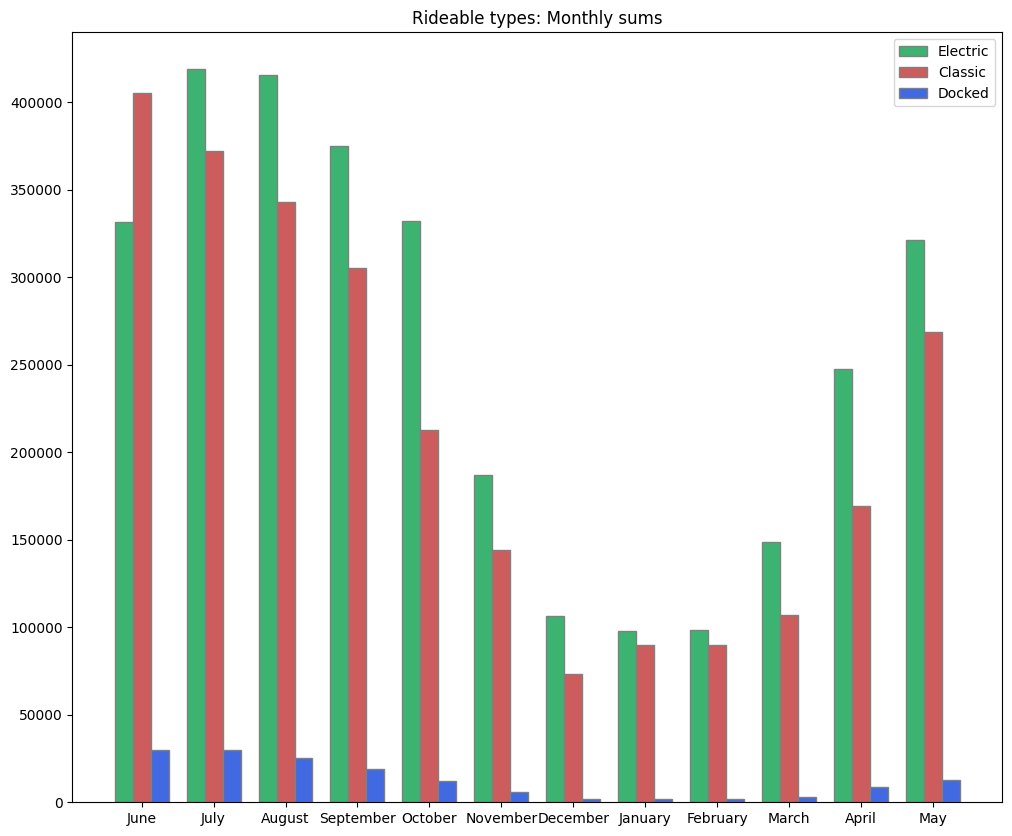

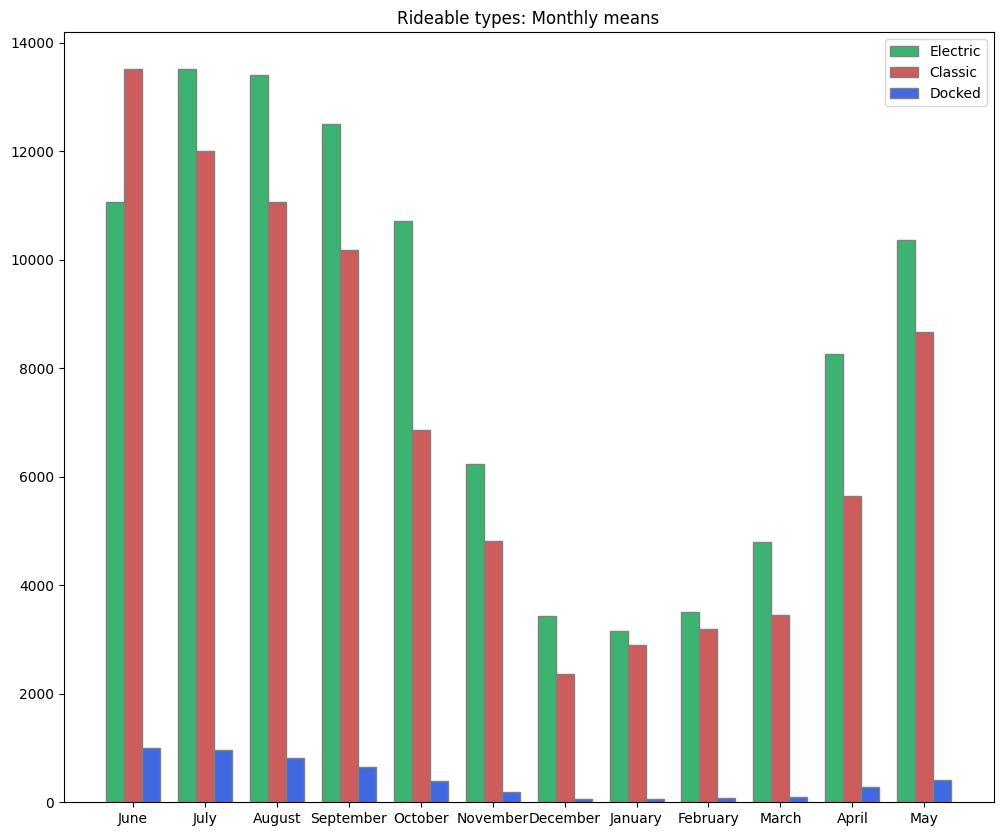

In [12]:
"""Rideable types
"""

"""Daily
"""
df_docked_count = getting_time_series(df_1, "rideable_type", "docked", "start_date")
#df_docked_count = df_docked_count.drop([df_docked_count.index[-1]])

df_classic_count = getting_time_series(df_1, "rideable_type", "classic", "start_date")
df_electric_count = getting_time_series(df_1, "rideable_type", "electric", "start_date")

"""Means by month: rideable_type
"""

df_docked_mean_month = grouping_time_series(df_docked_count, "mean")
df_classic_mean_month = grouping_time_series(df_classic_count, "mean")
df_electric_mean_month = grouping_time_series(df_electric_count, "mean")

"""Monthly
Sums by month: rideable_type
"""

df_docked_sum_month = grouping_time_series(df_docked_count, "sum")
df_classic_sum_month = grouping_time_series(df_classic_count, "sum")
df_electric_sum_month = grouping_time_series(df_electric_count, "sum")

"""Means by month: rideable_type
"""

df_docked_mean_month = grouping_time_series(df_docked_count, "mean")
df_classic_mean_month = grouping_time_series(df_classic_count, "mean")
df_electric_mean_month = grouping_time_series(df_electric_count, "mean")


## Line graphs
# Sum
#triple_line_graph(df_docked_sum_month, df_classic_sum_month, df_electric_sum_month, "Docked", "Classic", "Electric", "Rideable_type: Monthly sums")
# Mean
#triple_line_graph(df_docked_mean_month, df_classic_mean_month, df_electric_mean_month, "Docked", "Classic", "Electric", "Rideable_type: Monthly means")

## Bar graphs

# Sum
bar_graphs(df_electric_sum_month, df_classic_sum_month, df_docked_sum_month, "Electric", "Classic", "Docked", "Rideable types: Monthly sums")
# Mean
bar_graphs(df_electric_mean_month, df_classic_mean_month, df_docked_mean_month, "Electric", "Classic", "Docked", "Rideable types: Monthly means")



Checking for type of bikes and type of users by amount of trips, we discover that Docked bikes were not even used by Members during the period analyzed.

In [13]:
print("User vs Type of bike (thousands)")
user_ridetype = pd.crosstab(df_1["member_casual"], columns = df_1["rideable_type"])
user_ridetype["docked"] = user_ridetype["docked"]/1000
user_ridetype["electric"] = user_ridetype["electric"]/1000
user_ridetype["classic"] = user_ridetype["classic"]/1000
user_ridetype

User vs Type of bike (thousands)


rideable_type,classic,docked,electric
member_casual,,,
casual,852.428,152.12,1296.532
member,1728.555,0.00,1784.861


###Duration of trips

Now we calculate the total length by month, the daily mean length by month, and the mean length by trip. These three will be calculated in minutes, so we work with the same unit. This is easy to do because ride_length is a variable that's already in minutes.

In [14]:
"""Total length, daily mean length by month, and mean trip length.
"""

# From these dataframes, I need only need the index, trip_count, and ride_length columns:

df_1["trip_count"] = 1

df_month_sum = df_1.groupby(["month"]).sum().round(2)
df_month_mean = df_1.groupby(["month"]).mean().round(2)

# Here I can get the average per month
#Group trips per day
df_daily_sum = df_1.groupby(["start_date"]).sum().round(2)

#Add a column to count the days per month
df_daily_sum["daily_count"] = 1

#Turn start_date index to a column
df_daily_sum.reset_index(inplace = True)

#Create a column with the month's name based on start_date
df_daily_sum["month_name"] = pd.to_datetime(df_daily_sum["start_date"]).dt.month_name()

#Sum all columns by month
df_daily_sum = df_daily_sum.groupby(["month_name"]).sum().round(2)

#Calculate the monthly mean length dividing the ride_length
# by the number of days in a month.
df_daily_sum["monthly_mean"] = (df_daily_sum["ride_length"] / df_daily_sum["daily_count"]).round(2)
df_daily_sum["daily_mean_trip"] = (df_daily_sum["ride_length"] / df_daily_sum["trip_count"]).round(2)


#Reset index to use it as a column
df_daily_sum.reset_index(inplace= True)

#Drop innecessary columns
df_daily_sum = df_daily_sum.drop(["start_lat", "start_lng", "end_lat", "end_lng", "week_day_n", "month_n"], axis = 1)
df_daily_sum.rename(columns = {"ride_length":"ride_length_total_month",
                               "monthly_mean": "ride_length_monthly_mean",
                               "month_name":"month"}, inplace = True)

#Split the three series into single dataframes.

months = pd.DataFrame(df_docked_mean_month["month_name"], df_docked_mean_month.index)
months.reset_index(inplace = True)

df_daily_sum["ride_length_total_month"] = df_daily_sum["ride_length_total_month"].round(2)
df_daily_sum["ride_length_monthly_mean"] = df_daily_sum["ride_length_monthly_mean"].round(2)
df_daily_sum["daily_mean_trip"] = df_daily_sum["daily_mean_trip"].round(2)

months.rename(columns = {"month_name":"month"}, inplace = True)
x1 = df_daily_sum[["month", "ride_length_total_month"]]
x2 = df_daily_sum[["month", "ride_length_monthly_mean"]]
x3 = df_daily_sum[["month", "daily_mean_trip"]]

x1 = x1.merge(months, on= "month")
x2 = x2.merge(months, on= "month")
x3 = x3.merge(months, on = "month")

x1 = x1.sort_values(["date"])
x2 = x2.sort_values(["date"])
x3 = x3.sort_values(["date"])

x2.set_index("date", inplace = True)
x1.set_index("date", inplace = True)
x3.set_index("date", inplace = True)

<ipython-input-14-c84565e15df9>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month_sum = df_1.groupby(["month"]).sum().round(2)
<ipython-input-14-c84565e15df9>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month_mean = df_1.groupby(["month"]).mean().round(2)
<ipython-input-14-c84565e15df9>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily_sum = df_1.groupby(["start_date"]).sum().round(2)
<ipython-i

When we look at the total length of the trips per month and at their mean, these two series are very similar through the time. July is the month with more hours spent in trips by the users, while December is the one with the least.
But, if we see at the mean length by trip, June surpases to July in length of trips and December does the same with January.  

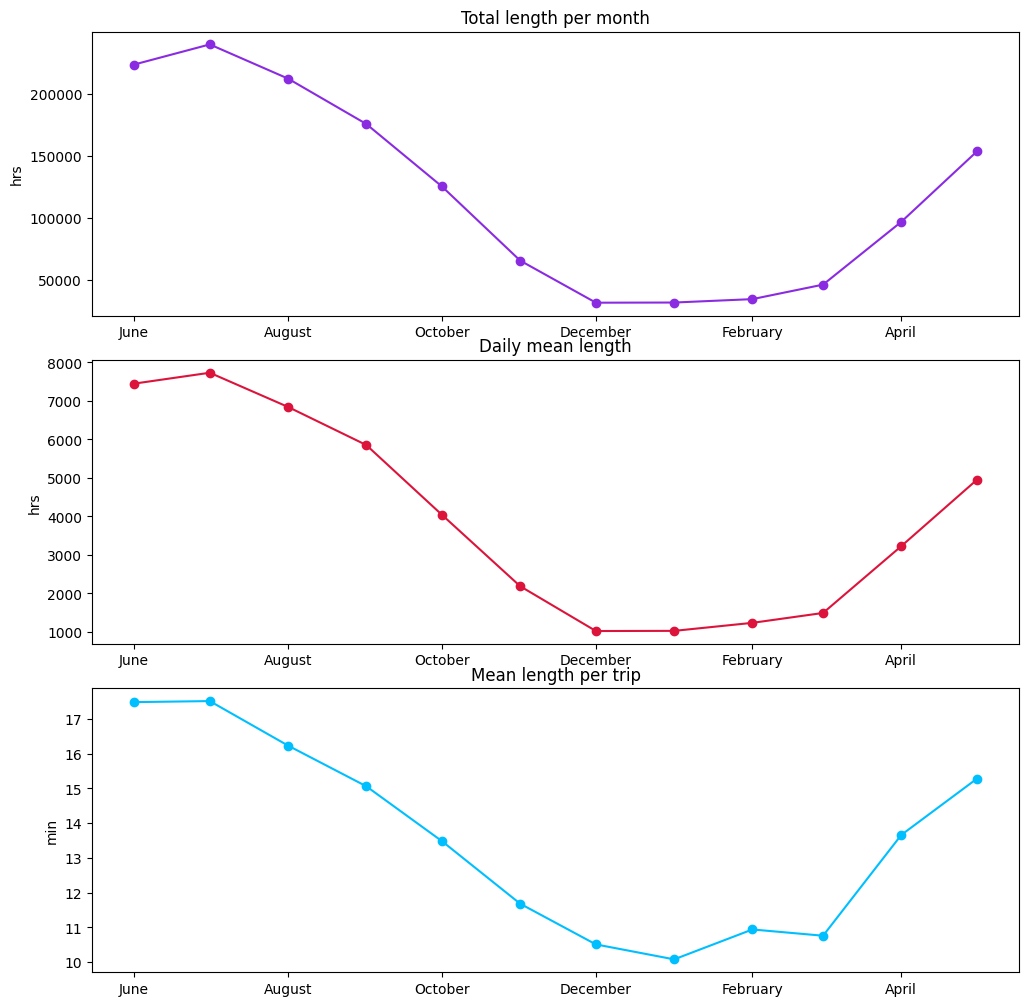

In [15]:
fig, (ax1, ax2, ax3) =  plt.subplots(3, 1, figsize = (10, 10))
fig.tight_layout()

ax1.plot(x1.index, x1["ride_length_total_month"]/60, "o-", color = "blueviolet")
ax1.set_xticks(x1.index[0:11:2], x1["month"][0:11:2])
ax1.set_title('Total length per month')
ax1.set(ylabel = 'hrs')

ax2.plot(x2.index, x2["ride_length_monthly_mean"]/60, "o-", color = "crimson")
ax2.set_xticks(x2.index[0:11:2], x2["month"][0:11:2])
ax2.set_title('Daily mean length')
ax2.set(ylabel = 'hrs')

ax3.plot(x3.index, x3["daily_mean_trip"], "o-", color = "deepskyblue")
ax3.set_xticks(x3.index[0:11:2], x3["month"][0:11:2])
ax3.set_title('Mean length per trip')
ax3.set(ylabel = 'min')

plt.show()

Looking closely to the daily mean length by month and the mean daily trip length, we can say that even when in July were more hours of use than in June, the mean length per trip in a day of both months were almost the same.

In general terms, we can say that daily mean length by month and mean trip length are higher in summer and lower in winter, when the weather goes between -6 to 3 celsius degrees. This relationship is supported by the high correlation coeficient of the two series, which is 0.9852.

Correlation between daily mean trip length and monthly mean length: 0.9884



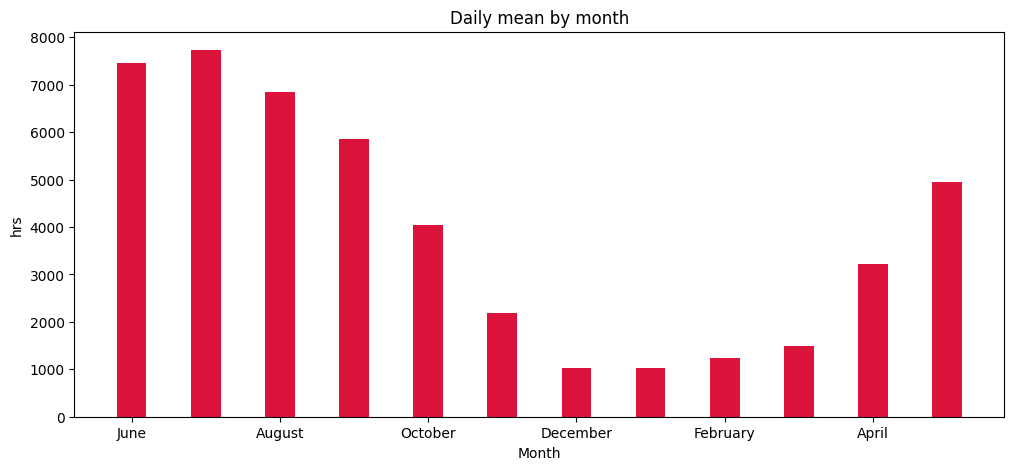

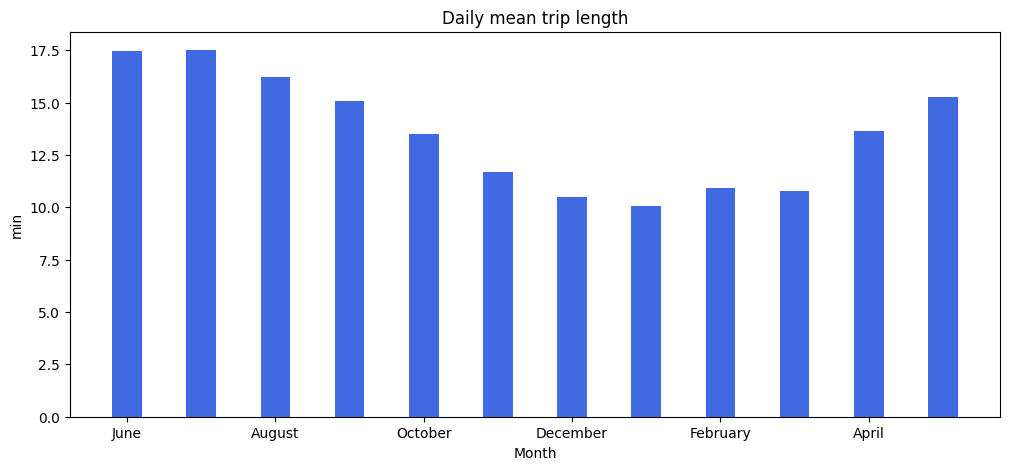

In [16]:
corr1 = x2["ride_length_monthly_mean"].corr(x3['daily_mean_trip'])
print(f"Correlation between daily mean trip length and monthly mean length: {corr1.round(4)}\n")

single_bar_graph(x2["month"], x2["ride_length_monthly_mean"]/60,
                 "Month", "hrs", "Daily mean by month", "crimson")
single_bar_graph(x3["month"], x3["daily_mean_trip"],
                 "Month", "min", "Daily mean trip length", "royalblue")


###Day analysis

We start by checking the amount of trips per day, and determining which was more popular for making trips.
Saturday was the most prefered by users, but there is not such a difference between it, Thursday and Wednesnay. By the other hand, Monday is the least prefered, followed by Sunday.

col_0       count
week_day         
Saturday   905599
Thursday   876501
Wednesday  869638
Friday     845920
Tuesday    821767
Sunday     767515
Monday     727556


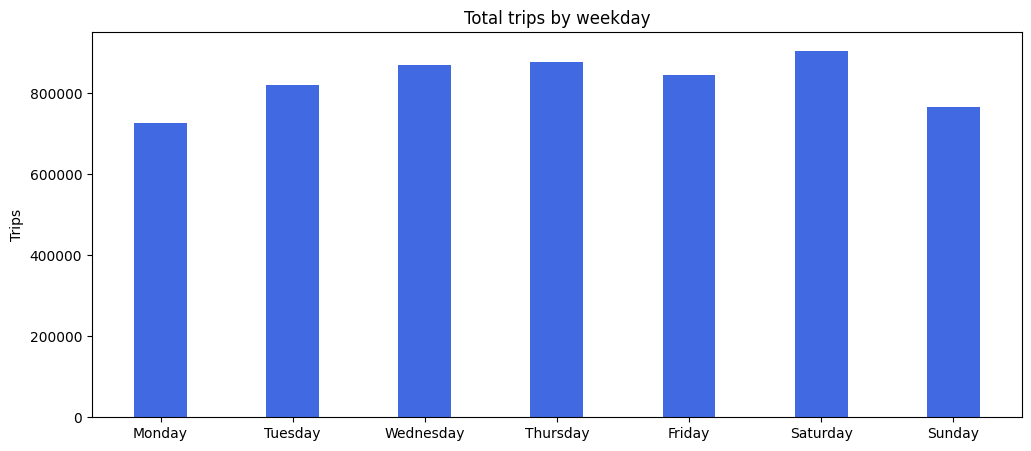

In [29]:
x4 = pd.crosstab(df_1["week_day_n"], columns = "count")
x4.reset_index(inplace = True)
x4["week_day"] = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
x4.set_index("week_day", inplace = True)
x4.drop(["week_day_n"], axis = 1, inplace = True)

print(x4.sort_values(by = "count", ascending = False))

single_bar_graph(x_axis= x4.index, y_axis= x4["count"],
                 x_label = None, y_label = "Trips", title_label = "Total trips by weekday", color = "royalblue",
                 frequency_x_label = 1)

The top 3 most popular days by month to do bike trips were:
 1. Tuesday (4 months)
 2. Saturday (3 months)
 3. Wednesday and Thursday (2 months)

We see that 3 of the 4 more popular days to do trips are weekdays, which may not be casualty. Combined with the short mean length per trip, we suggest that the service of Bike-Share is mainly used by people in regular activities like going to work or home.

In [30]:
top_week_day = df_1.groupby(["month"])["week_day"].describe()
print(top_week_day.sort_values(by = "top"))

            count unique        top    freq
month                                      
September  699624      7     Friday  128400
April      425509      7   Saturday   72882
July       821247      7   Saturday  163534
October    557477      7   Saturday  110102
December   181454      7   Thursday   35216
June       766841      7   Thursday  131104
August     783985      7    Tuesday  127964
February   190074      7    Tuesday   35432
January    189903      7    Tuesday   36223
May        603082      7    Tuesday  100798
March      258188      7  Wednesday   50976
November   337112      7  Wednesday   65147


##Share

As our analysis section made use of graphs and charts that supported the insights obtained, in this facet we would like to share an interactive report created in PowerBI with some of the visuals described in here.
[(Power BI report)](https://app.powerbi.com/view?r=eyJrIjoiMDE2OTI1MTEtOGVlMC00NzY1LWI1OTMtOTM1YWFjNzEwYTliIiwidCI6ImNhY2E5MDExLTdiNmEtNDRkZS04NjFmLTA5NWEyY2E4ODNiNyIsImMiOjR9)

In [ ]:
df_1.to_csv("biketrips_05-22_06-23_v4.csv", index = False)

##Act

Finally, we can resume our findings and answer the key questions that leaded this research.

Findings:
-	Summer was the season where more trips took place.
-	Members users don’t use Docked bike.
-	During the period analyzed, 3.51 millions (60.43%) of trips where made by members and 2.3 millions (39.57%) where made by casual users.
-	The most popular bike is the Electric one, which had a total of 3.1 millions of trips.
- Most of the trips took place in weekdays, and the mean duration of the trips was 14.85 minutes.
- Casual users represented almost 40% of the total of trips. This may be seen as an opportunity to gain more Members.

Key questions
-	How do annual members and casual riders use Cyclistic bikes differently?
 - R: Members are 50% more than casual riders. The reason behind this is that Chicago is a place where bikes are seen as an option to use daily to move in tasks like work, school, etc. Members do more trips than Casual during all the year, but they don't use Docked bikes.
-	Why would casual riders buy Cyclistic annual membership?
 - R: Casual rides may not see advantage in switching to an annual membership for some reasons that the data doesn't answer totally. So, we assumed that they prefer other ways to place themselves where they need to be, like public busses, metro, taxi, etc. Even with that, Casual riders are the only type of user that rides Docked bikes. A first way of attracting this sector could be implementing promotions for this specific kind of bycicle after getting an annual membership. As a second option, electric bikes are the most used by the casual consumer. Because of that, a marketing campaing can be focused over this service too.

-	How can Cyclistic use digital media to influence casual riders to become members?
 - R: Cyclistic should invest resources putting ads in social networks, being these the main source of information for the youngest generations. This campaing should be focused on advantages of Docked and Electric bikes during summer, where both consumer sectors do more trips.
 Finally, a reward-per-recomendation function could be added too, so users get a compensation for every new member that uses their personal code. Even new members could be compensated too with a discount. This discount and reward options should be introduced in months with few trips, like December, January and February to estimulate the demand.

##Acknowledges

I took more time than expected to finish this analysis. I was originally going to make it in two weeks but now it has been almost two months. These last months have been tough times for me and my family, so I just would like to thank my parents for all the support that they have given to me. But they say that tough times grow tough men up, so I am getting tougher everyday.
I also would like to thank you, reader, who's arrived here. Thank you for the opportunity to put an eye on my work and I hope you've found it interesting. You can send me any questions you have to my email arriaga_e99@outlook.com, where I'll be glad to clear them all.

In [ ]:
%%shell
jupyter nbconvert --to html /content/gdrive/MyDrive/Projects/Bike-share/Bike_share_project_v1.ipynb

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/Projects/Bike-share/Bike_share_project_v1.ipynb to html
[NbConvertApp] Writing 1157183 bytes to /content/gdrive/MyDrive/Projects/Bike-share/Bike_share_project_v1.html
